# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [1]:
# Import essential libraries for data manipulation and analysis
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Date and time handling
from datetime import datetime

# Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Importing the file porter_data_1.csv
df = pd.read_csv(r'C:\Users\yashb\Downloads\30688323-a1ea-4809-83c4-91d8096236c8-Delivery-Starter\Delivery_Starter\porter_data_1.csv')

# Display the first few rows
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [9]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Confirm the changes
print(df[['created_at', 'actual_delivery_time']].dtypes)




created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [11]:
# Convert categorical features to category type
categorical_cols = ['store_primary_category', 'order_protocol', 'market_id']

for col in categorical_cols:
    df[col] = df[col].astype('category')

# Confirm changes
print(df[categorical_cols].dtypes)


store_primary_category    category
order_protocol            category
market_id                 category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [13]:
# Calculate time taken in minutes
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the new column
print(df[['created_at', 'actual_delivery_time', 'delivery_duration']].head())

           created_at actual_delivery_time  delivery_duration
0 2015-02-06 22:24:17  2015-02-06 23:11:17               47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25               44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35               55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46               59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36               46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [15]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0).astype('category')

# Drop unnecessary columns (created_at and actual_delivery_time)
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

# View the updated DataFrame
print(df[['order_hour', 'order_dayofweek', 'isWeekend']].head())


   order_hour  order_dayofweek isWeekend
0          22                4         0
1          21                1         0
2           0                0         0
3           3                3         0
4           2                1         0


In [17]:
# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

KeyError: "['created_at', 'actual_delivery_time'] not found in axis"

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [19]:
# Define target variable (y) and features (X)

y = df['delivery_duration']

# Define input features by dropping the target
X = df.drop('delivery_duration', axis=1)

# Check the shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (175777, 15)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [21]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the shapes to confirm
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [23]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Define numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define categorical columns
categorical_cols = X_train.select_dtypes(include='category').columns.tolist()

# Output for verification
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical Columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

In [25]:
# Plot distributions for all numerical columns
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(18, 20))

# Loop over all numerical columns and plot histograms with KDE
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 2, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30, color='salmon')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

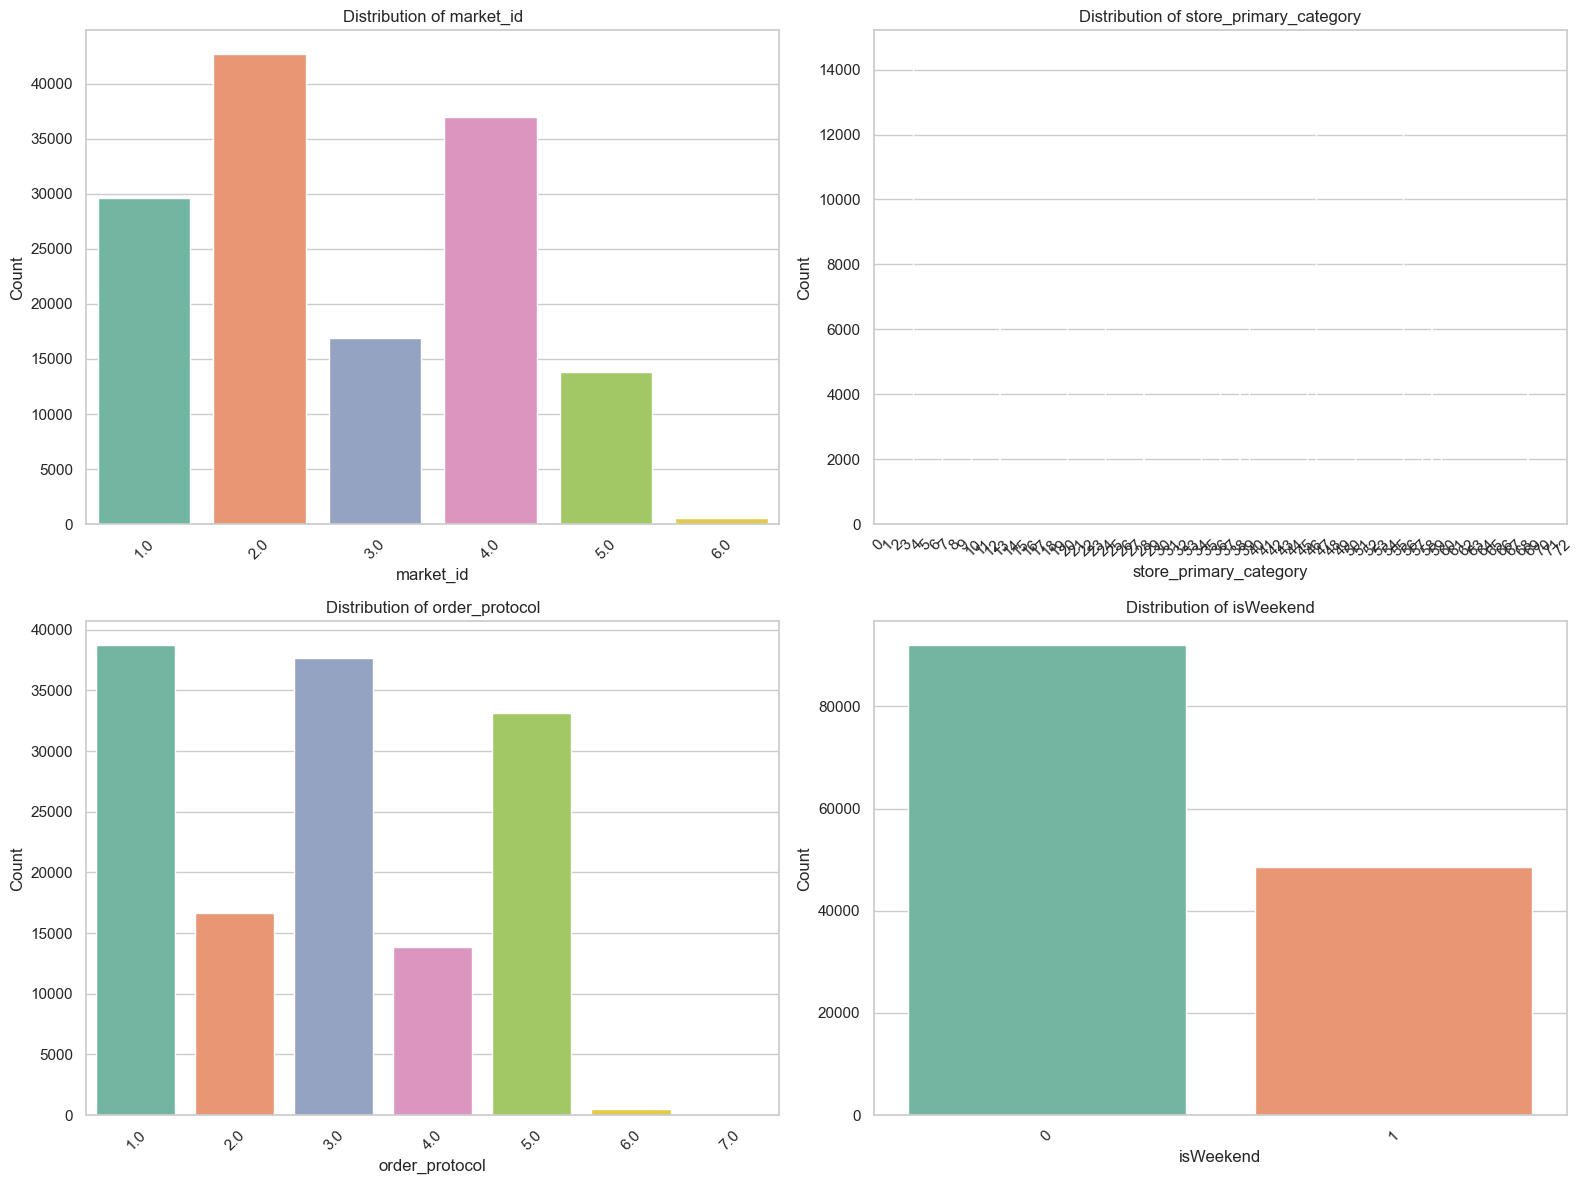

In [29]:
# Distribution of categorical columns

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

# Count plots for categorical features without the warning
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=X_train, x=col, hue=col, palette='Set2', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

In [31]:
# Distribution of time_taken

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=40, color='cornflowerblue')
plt.title('Distribution of Delivery Duration (time_taken)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

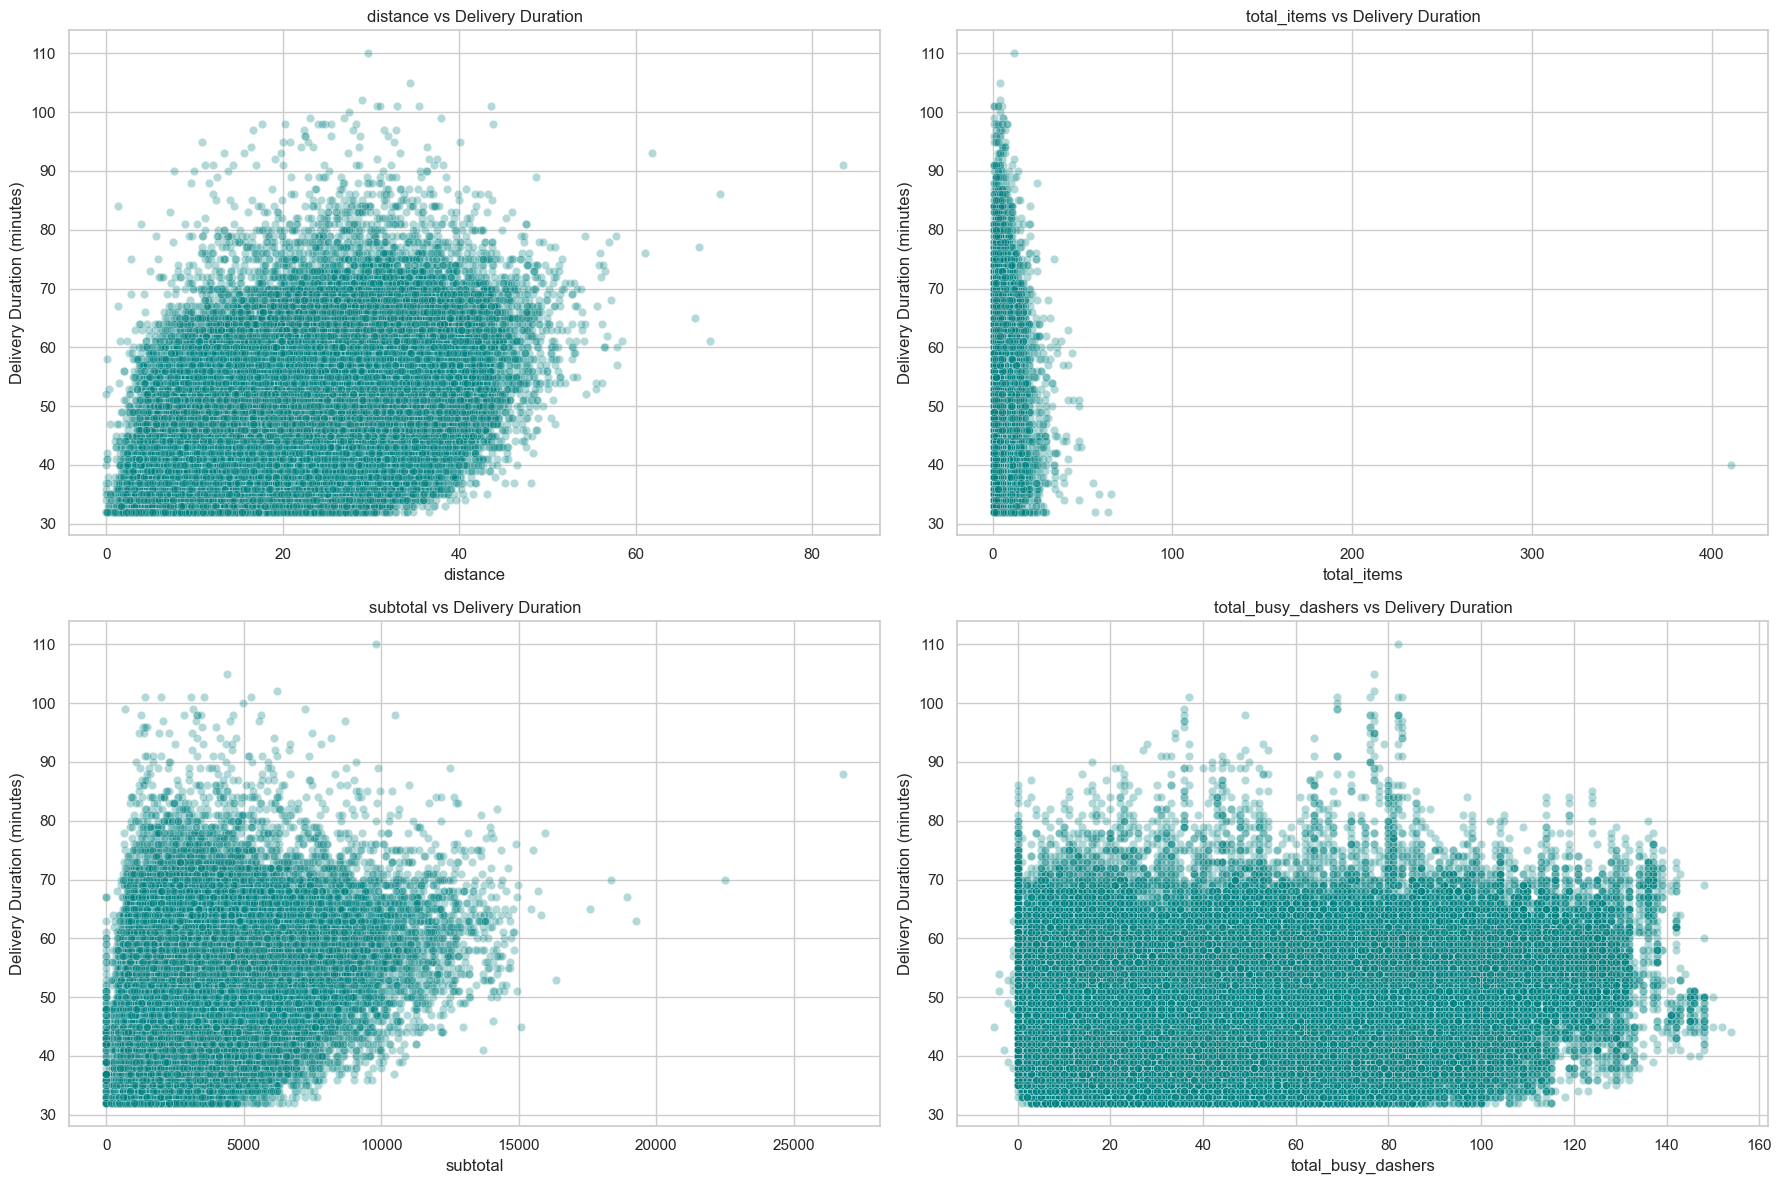

In [33]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(18, 12))
important_numerical = ['distance', 'total_items', 'subtotal', 'total_busy_dashers']

# Create scatter plots
for i, col in enumerate(important_numerical):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=X_train[col], y=y_train, alpha=0.3, color='teal')
    plt.title(f'{col} vs Delivery Duration')
    plt.xlabel(col)
    plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()


C:\Users\yashb\AppData\Local\Temp\ipykernel_15604\1843960106.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=X_train['order_hour'], y=y_train, palette='coolwarm')


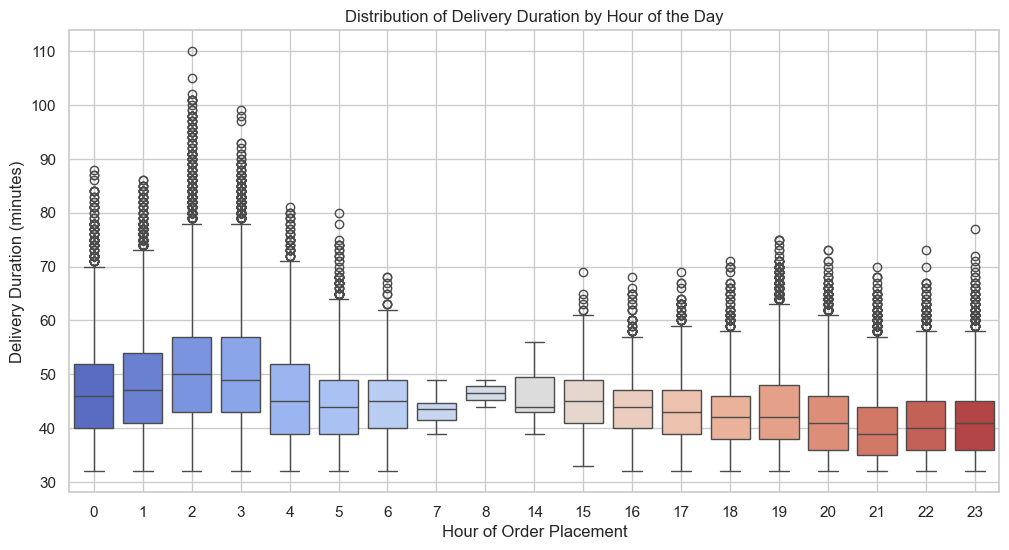

In [35]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['order_hour'], y=y_train, palette='coolwarm')
plt.title('Distribution of Delivery Duration by Hour of the Day')
plt.xlabel('Hour of Order Placement')
plt.ylabel('Delivery Duration (minutes)')
plt.grid(True)
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

In [37]:
# Plot the heatmap of the correlation matrix
train_df_corr = X_train.copy()
train_df_corr['delivery_duration'] = y_train

# Compute correlation matrix
corr_matrix = train_df_corr[numerical_cols + ['delivery_duration']].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features and Delivery Duration')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [41]:
# Step 1: Recalculate correlation matrix (if not already in memory)
train_df_corr = X_train.copy()
train_df_corr['delivery_duration'] = y_train
corr_matrix = train_df_corr[numerical_cols + ['delivery_duration']].corr()

# Step 2: Display correlation of each numerical feature with target
correlations_with_target = corr_matrix['delivery_duration'].drop('delivery_duration').sort_values()
print("Correlation of features with delivery_duration:")
print(correlations_with_target)

# List of weakly correlated features to drop
weak_features = ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers']

# Drop them from both training and testing sets
X_train.drop(columns=weak_features, inplace=True)
X_test.drop(columns=weak_features, inplace=True)

# Confirm the updated shape
print("Updated X_train shape:", X_train.shape)
print("Updated X_test shape:", X_test.shape)

Correlation of features with delivery_duration:
min_item_price              0.021151
total_onshift_dashers       0.171828
total_busy_dashers          0.206514
total_items                 0.220804
max_item_price              0.254650
num_distinct_items          0.312510
total_outstanding_orders    0.385028
subtotal                    0.413392
distance                    0.461026
Name: delivery_duration, dtype: float64
Updated X_train shape: (140621, 12)
Updated X_test shape: (35156, 12)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [46]:
# Boxplot for time_taken

# Boxplot for the target variable
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train)
plt.title('Boxplot of Delivery Duration')
plt.xlabel('Delivery Duration (minutes)')
plt.grid(True)
plt.show()

# Select numerical columns remaining after dropping weak features
numerical_cols_remaining = ['total_items', 'subtotal', 'num_distinct_items', 
                            'max_item_price', 'total_outstanding_orders', 'distance']

# Plot boxplots for numerical features in a grid
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols_remaining, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=X_train[col])
    plt.title(f'Boxplot of {col}')
    plt.grid(True)
plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [48]:
# Handle outliers

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

# Handle outliers in numerical features
for col in numerical_cols_remaining:
    cap_outliers_iqr(X_train, col)

# Also handle outliers in the target variable (delivery_duration)
cap_outliers_iqr(y_train.to_frame(), 'delivery_duration')

print("Outliers capped successfully.")

Outliers capped successfully.


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [50]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_cols_test = ['total_items', 'subtotal', 'num_distinct_items', 
                       'max_item_price', 'total_outstanding_orders', 'distance']

# Define categorical columns retained
categorical_cols_test = ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']

print("Numerical Columns in Test Data:", numerical_cols_test)
print("Categorical Columns in Test Data:", categorical_cols_test)

Numerical Columns in Test Data: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance']
Categorical Columns in Test Data: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [52]:
# Plot distributions for all numerical columns

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms with KDE for all numerical columns in the validation set
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols_test, 1):
    plt.subplot(3, 2, i)
    sns.histplot(X_test[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.grid(True)
plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

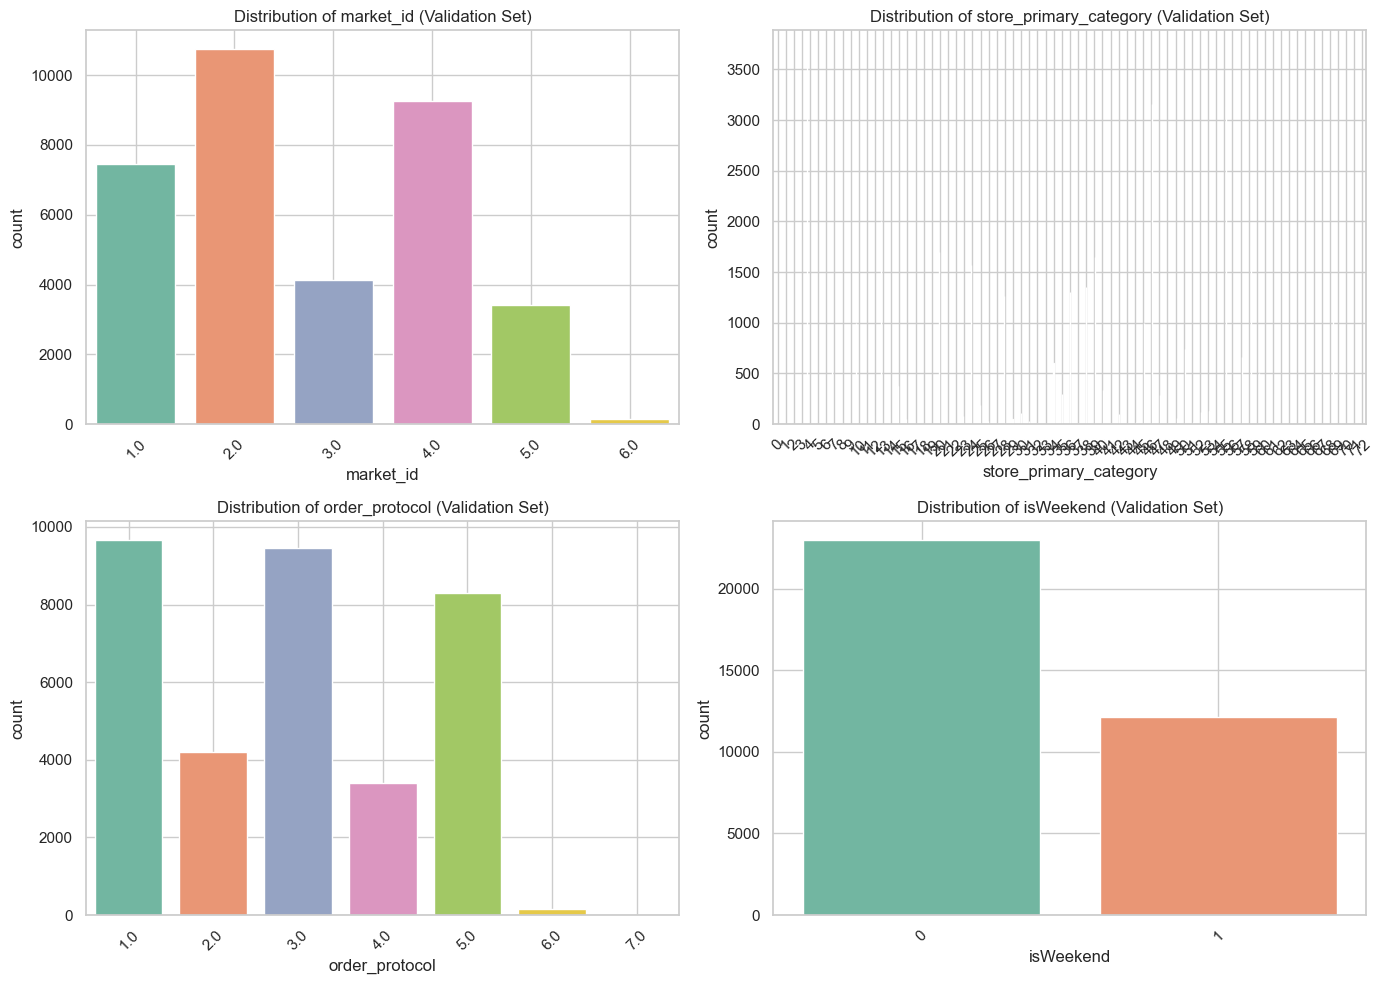

In [56]:
# Distribution of categorical columns

# Plot count plots for all categorical columns in the test set
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols_test, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=X_test, x=col, hue=col, palette='Set2', legend=False)
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.xticks(rotation=45)
    plt.grid(True)
plt.tight_layout()
plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

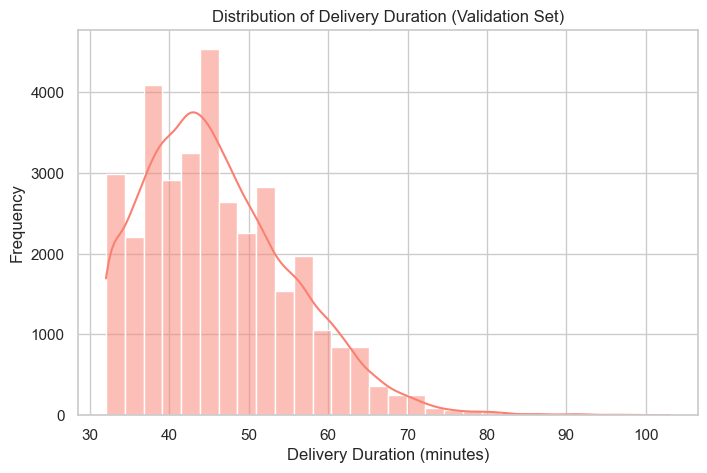

In [58]:
# Distribution of time_taken

plt.figure(figsize=(8, 5))
sns.histplot(y_test, kde=True, bins=30, color='salmon')
plt.title('Distribution of Delivery Duration (Validation Set)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

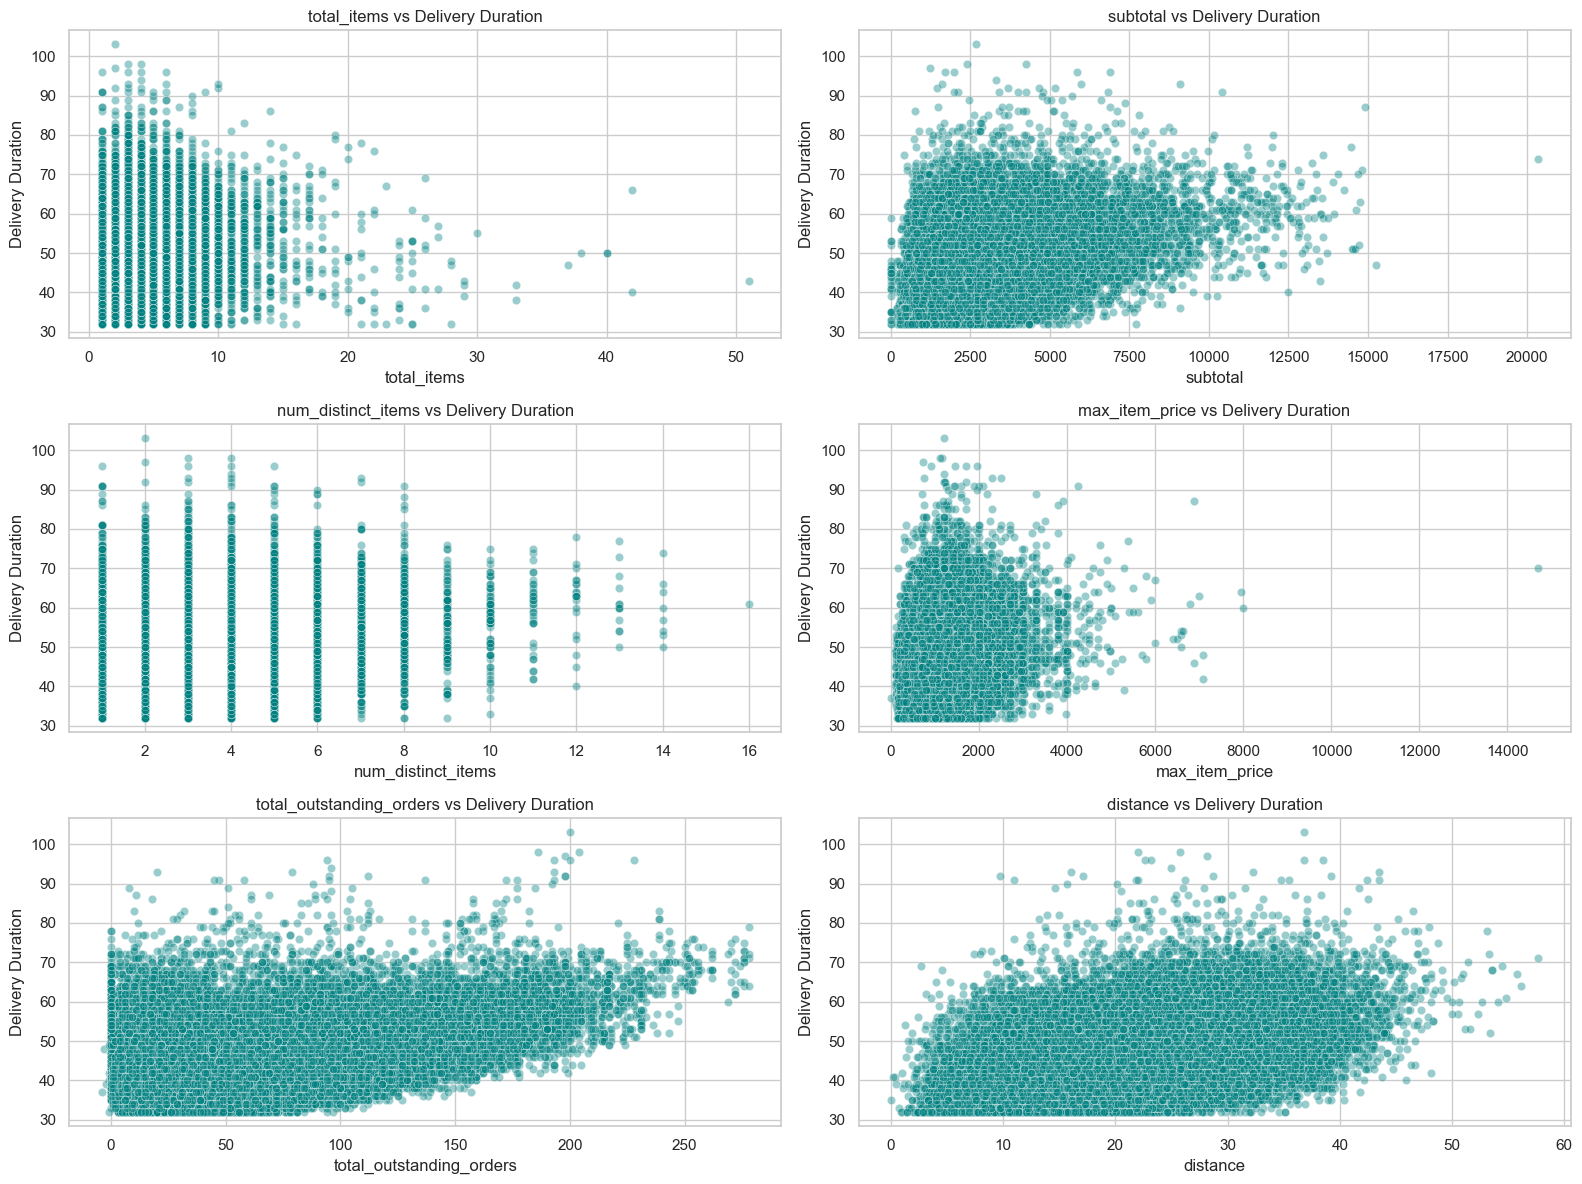

In [60]:
# Scatter plot to visualise the relationship between time_taken and other features

# List of numerical features
numerical_cols_test = ['total_items', 'subtotal', 'num_distinct_items', 
                       'max_item_price', 'total_outstanding_orders', 'distance']

# Plot scatter plots for numerical features against delivery_duration
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols_test, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=X_test[col], y=y_test, alpha=0.4, color='teal')
    plt.title(f'{col} vs Delivery Duration')
    plt.xlabel(col)
    plt.ylabel('Delivery Duration')
    plt.grid(True)

plt.tight_layout()
plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [64]:
# Drop the weakly correlated columns from training dataset

X_test.drop(['min_item_price', 'total_onshift_dashers', 'total_busy_dashers'], axis=1, inplace=True, errors='ignore')

# Confirm shape
print("Updated X_test shape:", X_test.shape)

Updated X_test shape: (35156, 12)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [66]:
# Import libraries

# Model libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For scaling if needed
from sklearn.preprocessing import StandardScaler


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [68]:
# Apply scaling to the numerical columns

from sklearn.preprocessing import StandardScaler

# Select numerical columns
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 
                  'max_item_price', 'total_outstanding_orders', 'distance']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform on training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform on test data using the same scaler
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [70]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Initialize the model
lr_model = LinearRegression()

# 2. Fit the model
lr_model.fit(X_train, y_train)

# 3. Predict on test data
y_pred = lr_model.predict(X_test)

# 4. Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# 5. Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 4.90
Mean Squared Error (MSE): 39.83
Root Mean Squared Error (RMSE): 6.31
R² Score: 0.5449


In [74]:
# Train the model using the training data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [78]:
# Make predictions
# Make predictions on the test set
y_pred = lr_model.predict(X_test_scaled)

# Show the first 5 predicted values
print("Sample Predictions:", y_pred[:5])

Sample Predictions: [53.87401991 55.60509827 36.01892379 38.64350991 39.6886458 ]


In [80]:
# Find results for evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 4.90
Mean Squared Error (MSE): 39.83
Root Mean Squared Error (RMSE): 6.31
R² Score: 0.5449


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [82]:
# Loop through the number of features and test the model

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Store evaluation results
rfe_results = []

# Loop from 1 to total number of features
total_features = X_train_scaled.shape[1]

for n in range(1, total_features + 1):
    # Initialize model and RFE
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n)
    
    # Fit RFE
    rfe.fit(X_train_scaled, y_train)
    
    # Transform the datasets
    X_train_rfe = rfe.transform(X_train_scaled)
    X_test_rfe = rfe.transform(X_test_scaled)
    
    # Fit model on reduced features
    model.fit(X_train_rfe, y_train)
    
    # Predict
    y_pred = model.predict(X_test_rfe)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    rfe_results.append((n, mae, mse, rmse, r2))

# Convert results to a DataFrame for easy viewing
import pandas as pd

rfe_df = pd.DataFrame(rfe_results, columns=['Num_Features', 'MAE', 'MSE', 'RMSE', 'R2_Score'])
print(rfe_df)


    Num_Features       MAE        MSE      RMSE  R2_Score
0              1  6.516492  69.266552  8.322653  0.208629
1              2  5.714081  55.847516  7.473120  0.361942
2              3  5.333062  46.695334  6.833398  0.466505
3              4  5.155376  44.216347  6.649537  0.494828
4              5  5.084806  43.554380  6.599574  0.502391
5              6  5.070915  42.725858  6.536502  0.511857
6              7  4.946865  40.861197  6.392276  0.533160
7              8  4.918068  39.932459  6.319213  0.543771
8              9  4.899235  39.791051  6.308015  0.545387
9             10  4.902337  39.845172  6.312303  0.544769
10            11  4.902320  39.837766  6.311717  0.544853
11            12  4.902634  39.834053  6.311422  0.544896


In [84]:
# Build the final model with selected number of features

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Define and fit RFE with 8 features
model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X_train_scaled, y_train)

# Step 2: Select features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

# Step 3: Subset the training and test sets
X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]

# Step 4: Train the final model
final_model = LinearRegression()
final_model.fit(X_train_rfe, y_train)

# Step 5: Predict and evaluate
y_pred_rfe = final_model.predict(X_test_rfe)

mae = mean_absolute_error(y_test, y_pred_rfe)
mse = mean_squared_error(y_test, y_pred_rfe)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rfe)

# Step 6: Print metrics
print(f"\nFinal Model with 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Selected Features: ['market_id', 'order_protocol', 'subtotal', 'total_outstanding_orders', 'distance', 'order_hour', 'order_dayofweek', 'isWeekend']

Final Model with 8 Features:
Mean Absolute Error (MAE): 4.92
Mean Squared Error (MSE): 39.93
Root Mean Squared Error (RMSE): 6.32
R² Score: 0.5438


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

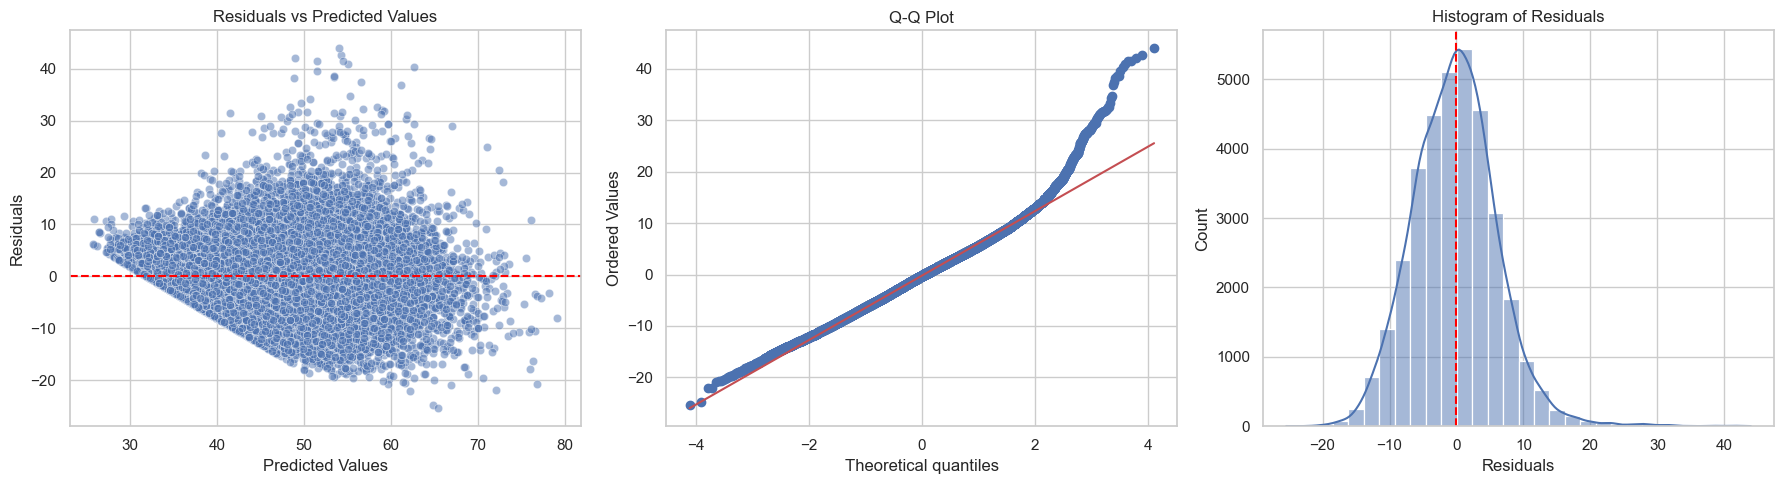

In [88]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
residuals = y_test - y_pred

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(18, 5))

# 1. Residuals vs Predicted Values
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

# 2. Q-Q Plot
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

# 3. Histogram of Residuals
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()



[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


Coefficient Analysis (Scaled Features):
                    Feature  Scaled Coefficient
4                  distance            4.023959
2                  subtotal            2.846709
3  total_outstanding_orders            2.515610
7                 isWeekend            2.087288
0                 market_id           -0.973539
1            order_protocol           -1.417283
5                order_hour           -1.546004
6           order_dayofweek           -1.607185


C:\Users\yashb\AppData\Local\Temp\ipykernel_15604\1632786243.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scaled Coefficient', y='Feature', data=coef_df, palette='coolwarm')


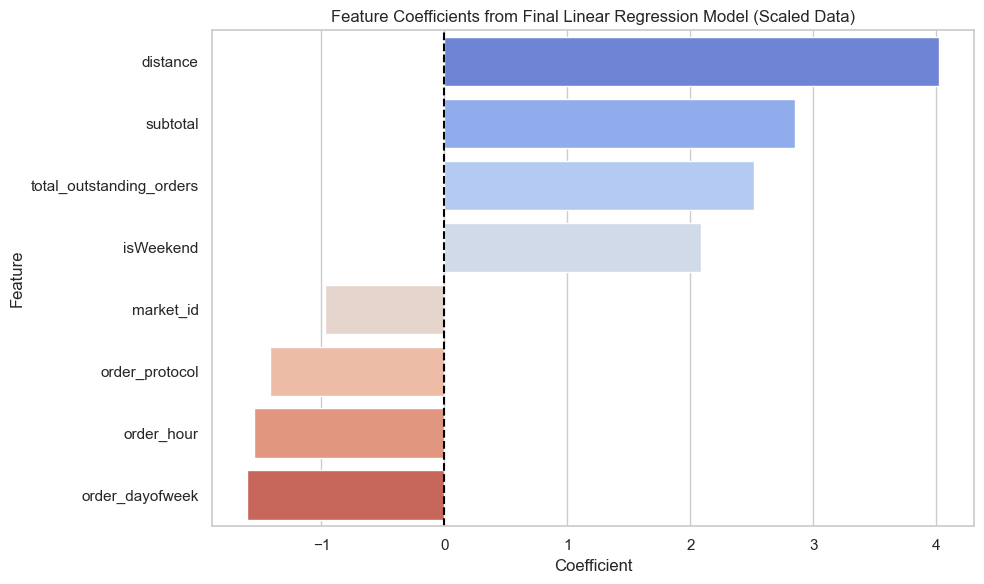

In [90]:
import pandas as pd
import numpy as np

# Get coefficients from the trained final model
coefficients = final_model.coef_

# Combine with feature names
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Scaled Coefficient': coefficients
})

# Sorting for better visualization
coef_df.sort_values(by='Scaled Coefficient', ascending=False, inplace=True)

# Display the coefficient dataframe
print("Coefficient Analysis (Scaled Features):")
print(coef_df)

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Scaled Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Feature Coefficients from Final Linear Regression Model (Scaled Data)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [96]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# Convert selected_features to list
selected_features_list = list(selected_features)

# Select a valid feature from the final model
feature_to_check = 'subtotal'

# Get the index of the feature
feature_index = selected_features_list.index(feature_to_check)

# Get the scaled coefficient
coef_scaled = final_model.coef_[feature_index]

# Get the standard deviation of that feature from original X_train
std_feature = X_train[feature_to_check].std()

# Unscale the coefficient
coef_unscaled = coef_scaled / std_feature

# Print results
print(f"Scaled Coefficient for {feature_to_check}: {coef_scaled:.4f}")
print(f"Standard Deviation of {feature_to_check}: {std_feature:.4f}")
print(f"Unscaled Coefficient (effect of one unit increase): {coef_unscaled:.4f} minutes")


Scaled Coefficient for subtotal: 2.8467
Standard Deviation of subtotal: 1.0000
Unscaled Coefficient (effect of one unit increase): 2.8467 minutes


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>

In [ ]:
Yes, there are categorical variables in the dataset. The key categorical features identified during exploratory data analysis are:
market_id
store_primary_category
order_protocol
isWeekend




---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

The parameter test_size = 0.2 refers to the proportion of the dataset that is reserved for testing when splitting the data into training and test sets.

---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>

From the heatmap and correlation values, the feature that has the highest correlation with the target variable delivery_duration is:

distance
Correlation coefficient: 0.4610

---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>

Approach to Detect Outliers:
To detect outliers, we used boxplots for the target variable (delivery_duration) and all important numerical features, including:

total_items
subtotal
num_distinct_items
max_item_price
total_outstanding_orders
distance

In boxplots, outliers appear as data points beyond the whiskers, which typically represent 1.5 times the interquartile range (IQR) above the third quartile (Q3) or below the first quartile (Q1)

---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>

Based on the final linear regression model built using the top 8 features (as selected by Recursive Feature Elimination), the top 3 features significantly affecting delivery time were:

Top 3 Influential Features:
subtotal
Effect: A higher order subtotal is associated with longer delivery time.
Reasoning: Larger or more expensive orders might take longer to prepare and deliver.

distance
Effect: Longer distances between the store and customer result in higher delivery time.
Reasoning: This is expected, as delivery time increases with geographic distance.

total_outstanding_orders
Effect: More outstanding orders at the store lead to increased delivery times.
Reasoning: High order volume may slow down kitchen preparation and order fulfillment.

---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear Regression Algorithm
Linear Regression is a supervised machine learning algorithm used to model the relationship between a dependent variable (target) and one or more independent variables (features) by fitting a linear equation to observed data.

 1. Mathematical Formulation:
For a simple linear regression (one independent variable):

 2. Objective:
To minimize the error between the actual and predicted values. This is done using Ordinary Least Squares (OLS) which minimizes the Sum of Squared Errors (SSE):

3. Assumptions of Linear Regression:
Linearity – Relationship between independent and dependent variables is linear

Homoscedasticity – Constant variance of residuals/errors

Independence – Observations are independent of each other

Normality – Residuals follow a normal distribution

No multicollinearity – Features should not be highly correlated with each other

 4. Advantages:
Easy to interpret
Computationally efficient
Works well with linearly separable data
Forms the basis for many advanced techniques

5. Limitations:
Assumes linear relationships
Sensitive to outliers
Performs poorly with multicollinearity or non-linear patterns

6. Use Case Example:
In this assignment, linear regression was used to predict delivery time (time_taken) based on variables like order subtotal, distance, number of outstanding orders, etc. The algorithm helped understand how each feature affects delivery duration

---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

Simple Linear Regression involves one independent variable and models a straight-line relationship with the dependent variable.
Example: Predicting delivery time based on distance only.

Multiple Linear Regression involves two or more independent variables to predict the dependent variable.
Example: Predicting delivery time based on distance, subtotal, and order protocol.

---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>


The cost function in linear regression measures how well the model's predictions match the actual data. The most commonly used cost function is the Mean Squared Error (MSE), which calculates the average of the squared differences between predicted and actual values.

The cost function is minimized using optimization techniques, typically Gradient Descent, which iteratively adjusts the model’s coefficients to find the values that result in the lowest error.

---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>

Overfitting occurs when a model learns not only the underlying patterns in the training data but also the noise. It performs well on training data but poorly on unseen data.

Underfitting happens when a model is too simple to capture the underlying structure of the data. It performs poorly on both training and test data.

---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>

In [ ]:
Residual plots help diagnose a linear regression model by:

Checking Linearity: Residuals should be randomly scattered around zero. Patterns may indicate non-linearity.
Detecting Heteroscedasticity: If residual spread increases or decreases, it shows non-constant variance.

Identifying Outliers: Points far from zero may be influential or erroneous observations.
These checks help validate model assumptions and improve reliability.